# Loading Libraries

In [1]:
import os
import shutil
import random
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from sklearn.model_selection import StratifiedShuffleSplit
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score, fbeta_score

colors = ['#648E9C', '#9CB1BC', '#C5D4DE', '#E8F1F4']
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

'cuda'

# Functions

## Visualization

In [3]:
# Function to plot samples
def plot_samples(images, N=5):
    ps = random.sample(range(0, images.shape[0]), N**2)
    f, axarr = plt.subplots(N, N, figsize=(10, 10))
    p = 0
    for i in range(N):
        for j in range(N):
            im = images[ps[p]].transpose(1, 2, 0)
            im = im / 2 + 0.5  # Unnormalize the image
            axarr[i, j].imshow(im)
            axarr[i, j].axis('off')
            p += 1
    plt.show()

## Train and Test

In [3]:
def correct_predictions(predicted_batch, label_batch):
    pred = predicted_batch.argmax(dim=1, keepdim=True)
    return pred.eq(label_batch.view_as(pred)).sum().item()

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    return total_params, trainable_params, non_trainable_params

def train_epoch(epoch, train_loader, network, optimizer, criterion, hparams, file_path):
    network.train()
    device = hparams['device']
    network.to(device)
    avg_loss = 0
    with open(file_path, 'a') as file:
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = network(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if batch_idx % hparams['log_interval'] == 0:
                file.write(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                           f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}\n')
    return avg_loss / len(train_loader)

def validation_epoch(validation_loader, network, hparams, file_path):
    network.eval()
    device = hparams['device']
    validation_loss = 0
    correct = 0
    with torch.no_grad(), open(file_path, 'a') as file:
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            validation_loss += F.cross_entropy(output, target, reduction='sum').item()
            correct += correct_predictions(output, target)
        validation_loss /= len(validation_loader.dataset)
        test_acc = 100. * correct / len(validation_loader.dataset)
        file.write(f'\nTest set: Average loss: {validation_loss:.4f}, Accuracy: {correct}/{len(validation_loader.dataset)} '
                   f'({test_acc:.0f}%)\n')
    return validation_loss, test_acc

## Plotting Results, Training and Testing Losses

In [5]:
def plot_history(train_history, val_history, metric='accuracy'):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_history[metric])
    plt.plot(val_history[metric])
    plt.title(f'Training and Validation {metric}')
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(train_history['loss'])
    plt.plot(val_history['loss'])
    plt.title('Training and Validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

In [6]:
def plot_and_save_results(tr_losses, te_losses, te_accs, model_name):
    # Plotting Training and Testing Losses
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(tr_losses, label='Training Loss', color='blue')
    plt.plot(te_losses, label='Testing Loss', color='red')
    plt.title(f'Training and Testing Loss Over Epochs - Model: {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Testing Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(te_accs, label='Testing Accuracy', color='green')
    plt.title(f'Testing Accuracy Over Epochs - Model: {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    # Save the figure
    plt.savefig(f"results.png")

    # Show the plot
    plt.show()

In [7]:
def display_results(y_true, y_preds, class_labels):
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                           columns=['Precision', 'Recall', 'F-Score', 'Support']).T
    results.columns = class_labels
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)

    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")
    
    return results, conf_mat

In [8]:
def plot_predictions(images, y_true, y_preds, class_indices, num_samples=20):
    
    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(len(images), size=num_samples, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        # Convert from PyTorch format (C, H, W) to image format (H, W, C)
        ax.imshow(images[idx].permute(1, 2, 0).cpu().numpy())
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
        
        # Set title with predicted and true labels
        ax.set_title(f"{class_indices[pred_idx]}\n(True: {class_indices[true_idx]})", 
                     color=("green" if pred_idx == true_idx else "red"))

    plt.tight_layout()
    plt.show()

## Setting-up Hyperparameters

In [9]:
hparams = {
    'batch_size': 64,
    'num_epochs': 10,
    'learning_rate': 0.001,
    'weight_decay': 0.001,
    'log_interval': 10,
    'device': device,
    'num_classes': 10
}

## Brief Overview of the Data

In [10]:
DATASET = "./data/EuroSAT_RGB"

LABELS = os.listdir(DATASET)
print(LABELS)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


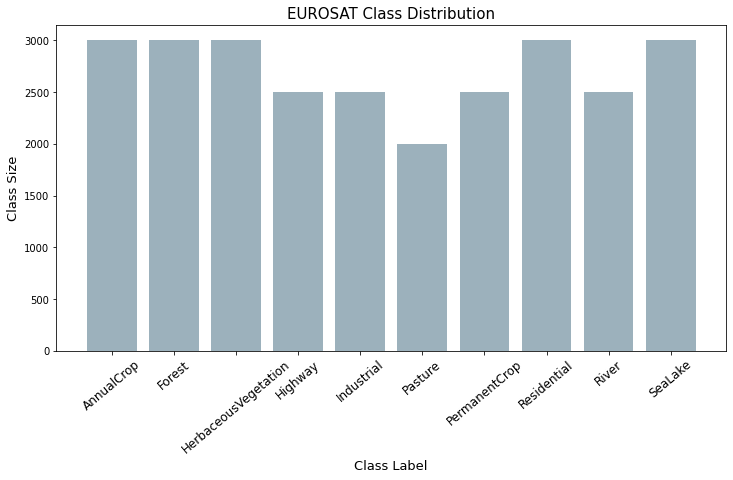

In [11]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center', color= colors[1])
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('Class Label', fontsize=13)
plt.ylabel('Class Size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

In [12]:
print(f'Dataset Size: {sum(counts.values())}')

Dataset Size: 27000


The dataset is split into 10 classes of land cover. Each class varies in size, so I'll have to stratify later on when splitting the data into training, testing and validation sets.

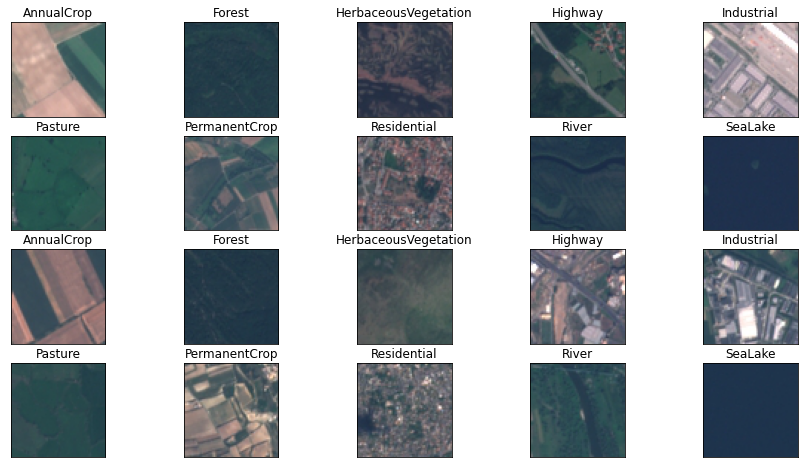

In [13]:
img_paths = [os.path.join(DATASET, l, l+'_1000.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(DATASET, l, l+'_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)


Upon reviewing the various class previews, we observe certain commonalities and distinct contrasts among them.

Classes depicting urban settings like `Highways`, `Residential` areas, and `Industrial` sites predominantly feature man-made structures and roadways.

Both `AnnualCrops` and `PermanentCrops` classes display agricultural areas, characterized by straight lines marking different crop fields.

In contrast, classes such as `HerbaceousVegetation`, `Pasture`, and `Forests` represent natural landscapes. `Rivers`, also a part of the natural landscape category, are somewhat more distinguishable from these other natural classes.

Analyzing the imagery content might give insights into potential class confusions. For instance, a `River` image could be misidentified as a `Highway`. Similarly, an image showing a highway junction with nearby buildings might be confused for an `Industrial` area. To overcome these challenges, it's crucial to develop a classifier that can adeptly discern these subtle differences.

Regarding Sentinel-2 satellite imagery, it's possible to access over 10 additional spectral bands. For instance, the `Near-Infrared Radiation (NIR)` band is available in this dataset and can be utilized to create indices that visualize the presence or absence of radiation in an image. However, this dataset lacks NIR wavelength bands, rendering this approach infeasible for our current analysis. Nonetheless, it's important to note that NIR data could offer an alternative method for tackling this classification task.

# Preprocessing

## Creating Train, Validation and Test Directories

In [14]:
TRAIN_DIR = './data/train'
VALID_DIR = './data/valid'
TEST_DIR = './data/test'

os.makedirs(TRAIN_DIR,exist_ok=True)
os.makedirs(VALID_DIR,exist_ok=True)
os.makedirs(TEST_DIR,exist_ok=True)

# create class label subdirectories in train and test
for l in LABELS:
    os.makedirs(os.path.join(TRAIN_DIR, l), exist_ok=True)
    os.makedirs(os.path.join(VALID_DIR, l), exist_ok=True)
    os.makedirs(os.path.join(TEST_DIR, l), exist_ok=True)

## Splitting Data to Train and Test

## Uncomment Code Below when Run for First Time

In [ ]:
data = {os.path.join(DATASET, l, img): l for l in LABELS for img in os.listdir(os.path.join(DATASET, l))}

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

In [ ]:
# Split and process paths
for train_idx, test_idx in split.split(X, y):
    train_paths = X[train_idx].tolist()
    test_paths = X[test_idx].tolist()

    # Define new paths without using regex
    new_train_paths = [path.replace(DATASET, TRAIN_DIR) for path in train_paths]
    new_test_paths = [path.replace(DATASET, TEST_DIR) for path in test_paths]

    train_path_map = zip(train_paths, new_train_paths)
    test_path_map = zip(test_paths, new_test_paths)
    
    # Move the files
    print("Moving training files..")
    for old_path, new_path in tqdm(train_path_map):
        os.makedirs(os.path.dirname(new_path), exist_ok=True)
        if not os.path.exists(new_path):
            shutil.copy(old_path, new_path)
    
    print("Moving testing files..")
    for old_path, new_path in tqdm(test_path_map):
        os.makedirs(os.path.dirname(new_path), exist_ok=True)
        if not os.path.exists(new_path):
            shutil.copy(old_path, new_path)

In [15]:
# Define transformations for training
mean = [0.485, 0.456, 0.406] # Adjust as needed
std = [0.229, 0.224, 0.225] # Adjust as needed

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(60),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  
])

# Define transformations for testing (only normalization)
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  
])

# Create the dataset and dataloader for training
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)

# Optionally create the dataset and dataloader for validation
# valid_dataset = datasets.ImageFolder(root=VALID_DIR, transform=test_transforms)
# valid_loader = DataLoader(valid_dataset, batch_size=hparams['batch_size'], shuffle=False, num_workers=4)

# Create the dataset and dataloader for testing
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=hparams['batch_size'], shuffle=False)

In [16]:
print(f'Train Dataset Size: {len(train_dataset)}')
print(f'Test Dataset Size: {len(test_dataset)}')

Train Dataset Size: 21600
Test Dataset Size: 5400


In [17]:
# Get Class indices dictionary
class_indices = train_dataset.class_to_idx
print(class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [18]:
# Save the class indices
np.save('class_indices.npy', class_indices)

## Visualize the Preprocessed Data

In [19]:
# Fetch the first batch of images from the trainloader
first_batch_images, _ = next(iter(train_loader))
first_image = first_batch_images[0].unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

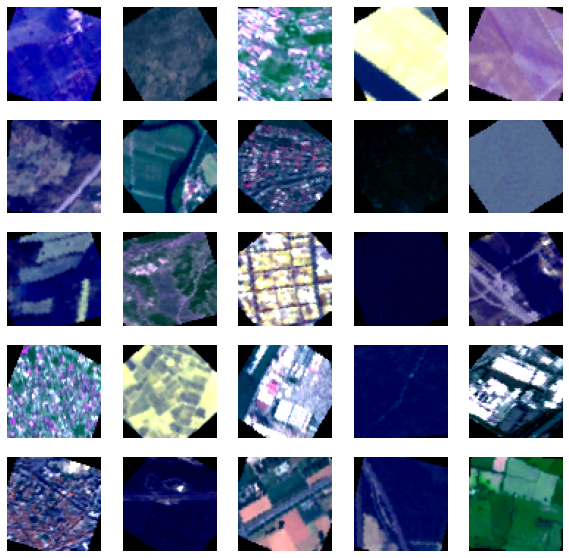

In [20]:
first_batch_images_np = first_batch_images.numpy()

# Plot samples from the first batch
plot_samples(first_batch_images_np)

# Model Instantiation

## EUROSatCNN

In [21]:
class EUROSatCNN(nn.Module):
    def __init__(self, num_classes):
        super(EUROSatCNN, self).__init__()
        self.num_classes = num_classes

        # First set of convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        # Second set of convolutional layers
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.LeakyReLU()
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(2, 2) 
        self.dropout2 = nn.Dropout(0.25)

        # Third set of convolutional layers
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.relu5 = nn.LeakyReLU()
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.relu6 = nn.LeakyReLU()
        self.pool3 = nn.MaxPool2d(2, 2)  # output size: 8x8
        self.dropout3 = nn.Dropout(0.25)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 128)  # 8x8 is the size after pooling layers
        self.relu7 = nn.LeakyReLU()
        self.dropout4 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, self.num_classes)  # Assuming 10 classes
    
    def forward(self, x):
        # First set of layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # Second set of layers
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # Third set of layers
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten the output
        x = self.flatten(x)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu7(x)
        x = self.dropout4(x)
        x = self.fc2(x)

        return x

# Training Process

In [22]:
def compile_model(cnn_base, num_classes, fine_tune=None):
    # Choose the base model and modify the classifier
    if cnn_base in ['ResNet50', 'ResNet152V2']:
        if cnn_base == 'ResNet50':
            model = models.resnet50(pretrained=True)
        elif cnn_base == 'ResNet152V2':
            model = models.resnet152(pretrained=True)
        else:
            print("Wrong CNN base")
        
        # Modify the fully connected layer
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, num_classes)
        )
    
    elif cnn_base in ['VGG16', 'VGG19']:
        if cnn_base == 'VGG16':
            model = models.vgg16(pretrained=True)
        else:  # VGG19
            model = models.vgg19(pretrained=True)

        # Modify the classifier part of VGG
        num_ftrs = 512 * 7 * 7  # this is 25088 for 64x64 input images
        model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, num_classes)
        )
    elif cnn_base == "EUROSatCNN":
        model = EUROSatCNN(num_classes)

    # Set the fine-tuning
    if fine_tune is not None:
        for param in model.parameters():
            param.requires_grad = False
        for param in list(model.parameters())[fine_tune:]:
            param.requires_grad = True
    
    print('-------------------------------------------------------------------\n')
    print(model)
    print('-------------------------------------------------------------------\n')
    total_params, trainable_params, non_trainable_params = count_parameters(model)
    print(f"Total parameters in the model: {total_params}")
    print(f"Trainable parameters in the model: {trainable_params}")
    print(f"NON-Trainable parameters in the model: {non_trainable_params}")
    print('-------------------------------------------------------------------\n')

    return model

# Training Process

In [23]:
def training_process(network, nework_name):
    # Initialize variables for Early Stopping and Model Checkpoint
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    patience = 10  # For early stopping
    model_path = f'{nework_name}_model_best.pth'

    # Define the optimizer with or without L2 regularization
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, network.parameters()), lr=hparams['learning_rate'], weight_decay=hparams['weight_decay'])

    # Define the criterion
    criterion = nn.CrossEntropyLoss()

    # Initialize ReduceLROnPlateau scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, min_lr=0.001)

    early_stopping_triggered = False


    # Training and validation loop
    tr_losses, te_losses, te_accs = [], [], []

    # Start the timer
    start_time = time.time()

    for epoch in range(1, hparams['num_epochs'] + 1):
        train_loss = train_epoch(epoch, train_loader, network, optimizer, criterion, hparams, f'../open_project/{nework_name}_training_log.txt')
        tr_losses.append(train_loss)
        test_loss, test_acc = validation_epoch(test_loader, network, hparams, f'../open_project/{nework_name}_validation_log.txt')
        te_losses.append(test_loss)
        te_accs.append(te_accs)

        # Model Checkpoint
        if test_acc > best_val_accuracy:
            best_val_accuracy = test_acc
            torch.save(network.state_dict(), model_path)
            print(f"Checkpoint saved at {model_path}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early Stopping
        if epochs_no_improve == patience:
            print("Early stopping triggered. Exiting training loop.")
            early_stopping_triggered = True
            break

        # Learning Rate Scheduler Step
        scheduler.step(test_acc)

    if not early_stopping_triggered:
        print("Completed training for {} epochs".format(hparams['num_epochs']))
    
    # Stop the timer
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Convert elapsed time to minutes and seconds
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time % 60)

    print(f'Total Training Time: {elapsed_mins}m {elapsed_secs}s')
    
    plot_and_save_results(tr_losses, te_losses, te_accs, nework_name)

# VGG16 No Fine Tuning

In [ ]:
# vgg16_no_fine_tune = compile_model('VGG16', hparams['num_classes'], fine_tune=None)

In [24]:
train_dataset[0][0].shape

torch.Size([3, 64, 64])

In [ ]:
# NO WAY THIS RUN ON MY LAPTOP
# training_process(vgg16_no_fine_tune, "vgg16_no_fine_tune")

# EUROSatCNN No Fine Tuning

In [25]:
EUROSatCNN_no_fine_tune = compile_model('EUROSatCNN', hparams['num_classes'], fine_tune=None)

-------------------------------------------------------------------

EUROSatCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [26]:
training_process(EUROSatCNN_no_fine_tune, "EUROSatCNN_no_fine_tune")

Train Epoch: 1 [0/21600 (0%)]	Loss: 2.388064
Train Epoch: 1 [640/21600 (3%)]	Loss: 2.190535
Train Epoch: 1 [1280/21600 (6%)]	Loss: 2.280423
Train Epoch: 1 [1920/21600 (9%)]	Loss: 1.852700
Train Epoch: 1 [2560/21600 (12%)]	Loss: 1.679652
Train Epoch: 1 [3200/21600 (15%)]	Loss: 1.836633
Train Epoch: 1 [3840/21600 (18%)]	Loss: 1.825329
Train Epoch: 1 [4480/21600 (21%)]	Loss: 1.817169
Train Epoch: 1 [5120/21600 (24%)]	Loss: 1.788864
Train Epoch: 1 [5760/21600 (27%)]	Loss: 1.861836
Train Epoch: 1 [6400/21600 (30%)]	Loss: 1.570976
Train Epoch: 1 [7040/21600 (33%)]	Loss: 1.463160
Train Epoch: 1 [7680/21600 (36%)]	Loss: 1.569435
Train Epoch: 1 [8320/21600 (38%)]	Loss: 1.619830
Train Epoch: 1 [8960/21600 (41%)]	Loss: 1.660790
Train Epoch: 1 [9600/21600 (44%)]	Loss: 1.529918
Train Epoch: 1 [10240/21600 (47%)]	Loss: 1.423202
Train Epoch: 1 [10880/21600 (50%)]	Loss: 1.434106
Train Epoch: 1 [11520/21600 (53%)]	Loss: 1.412558
Train Epoch: 1 [12160/21600 (56%)]	Loss: 1.499823
Train Epoch: 1 [12800/21

: 

# Model Evaluation

In [ ]:
model = 
model_path = "EUROSatCNN_no_fine_tune_model_best.pth"
network.load_state_dict(torch.load(model_path, map_location=device))
network.eval()

In [ ]:
# Load a batch of images and their labels from the test_loader
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Predict labels
EUROSatCNN_no_fine_tune.eval()
with torch.no_grad():
    outputs = EUROSatCNN_no_fine_tune(images)
    _, predicted = torch.max(outputs, 1)

# Map predicted and true labels back to class names
predicted_labels = [class_indices[idx] for idx in predicted.cpu().numpy()]
true_labels = [class_indices[idx] for idx in labels.cpu().numpy()]

# Visualize predictions
plot_predictions(images, true_labels, predicted_labels, class_indices, num_samples=20)